### Load Data

In [5]:
import pandas as pd       
train = pd.read_csv("user_reviews.csv")

In [6]:
train.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


In [7]:
train.shape

(2999, 4)

In [11]:
train.columns.values

array(['grade', 'user_name', 'text', 'date'], dtype=object)

In [17]:
from bs4 import BeautifulSoup             

example1 = BeautifulSoup(train["text"][0])  

# Print the raw review and then the output of get_text(), for 
# comparison
print(train["text"][0])
print()
print(example1.get_text())

My gf started playing before me. No option to create my own island and guys, being the 2nd player to start on a console SUCKS!!!! You miss out on so much that only the 1st player gets in terms of activities, resources, etc. It's absolutely terrible. You have to buy a 2nd console if more than one person in your household wants to get the full game experience. That's unacceptable.

My gf started playing before me. No option to create my own island and guys, being the 2nd player to start on a console SUCKS!!!! You miss out on so much that only the 1st player gets in terms of activities, resources, etc. It's absolutely terrible. You have to buy a 2nd console if more than one person in your household wants to get the full game experience. That's unacceptable.


### Data Cleaning and Text Preprocessing

In [18]:
import re
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print(letters_only)


My gf started playing before me  No option to create my own island and guys  being the  nd player to start on a console SUCKS     You miss out on so much that only the  st player gets in terms of activities  resources  etc  It s absolutely terrible  You have to buy a  nd console if more than one person in your household wants to get the full game experience  That s unacceptable 


In [19]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

In [23]:
import nltk
nltk.download()  # Download text data sets, including stop words

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [103]:
def review_to_wordlist( review, remove_stopwords=False, word_string=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    if word_string:  
    # the string make it easier to use in our Bag of Words
        return ( " ".join(words)) 
    
    return words

In [107]:
# Get the number of reviews based on the dataframe column size
num_UR = train["text"].size

# Initialize an empty list to hold the clean reviews
clean_train_UR = []

for i in range(num_UR):
    clean_train_UR.append(review_to_wordlist(train["text"][i],remove_stopwords=True,word_string=True))

In [105]:
# Final product after preprocessing
clean_train_UR[0]

'gf started playing option create island guys nd player start console sucks miss much st player gets terms activities resources etc absolutely terrible buy nd console one person household wants get full game experience unacceptable'

In [115]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000)    #5000 most frequent words

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_UR)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [116]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab[:10]

['ability',
 'able',
 'absolute',
 'absolutely',
 'ac',
 'access',
 'account',
 'accounts',
 'acnh',
 'across']

In [117]:
import numpy as np
import csv

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
hot_words = pd.DataFrame({"Word":vocab,'Counts':dist})

In [118]:
hot_words = hot_words.sort_values('Counts', ascending = False)
# Top 10 key words in user reviews
hot_words[:10]

,Word,Counts
358,game,8978
459,island,4041
632,one,3246
853,switch,2253
670,play,2192
672,player,1890
611,nintendo,1823
661,per,1626
172,console,1522
607,new,1440


In [119]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

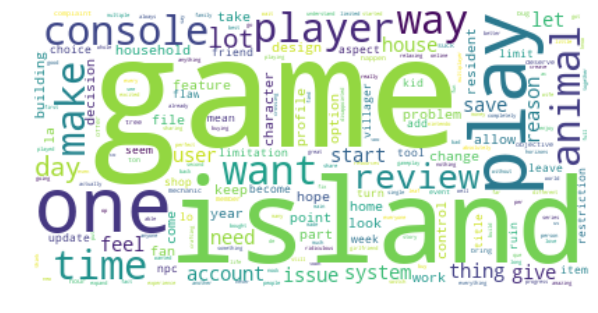

In [120]:
text = " ".join(review for review in hot_words['Word'])
wordcloud = WordCloud(background_color="white").generate(text)
fig = plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Using Word2Vec

Word2Vec expects single sentences, each one as a list of words. Thus the input format is a list of lists.

In [122]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [123]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip()) # .strip removes the leading and ending spaces
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [124]:
review_to_sentences(train['text'][0], tokenizer, remove_stopwords=False )

[['my', 'gf', 'started', 'playing', 'before', 'me'],
 ['no',
  'option',
  'to',
  'create',
  'my',
  'own',
  'island',
  'and',
  'guys',
  'being',
  'the',
  'nd',
  'player',
  'to',
  'start',
  'on',
  'a',
  'console',
  'sucks'],
 ['you',
  'miss',
  'out',
  'on',
  'so',
  'much',
  'that',
  'only',
  'the',
  'st',
  'player',
  'gets',
  'in',
  'terms',
  'of',
  'activities',
  'resources',
  'etc'],
 ['it', 's', 'absolutely', 'terrible'],
 ['you',
  'have',
  'to',
  'buy',
  'a',
  'nd',
  'console',
  'if',
  'more',
  'than',
  'one',
  'person',
  'in',
  'your',
  'household',
  'wants',
  'to',
  'get',
  'the',
  'full',
  'game',
  'experience'],
 ['that', 's', 'unacceptable']]

In [127]:
# Preparing data for input to Word2Vec
sentences = []  # Initialize an empty list of sentences

for review in train["text"]:
    sentences += review_to_sentences(review, tokenizer)

In [129]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2020-05-16 18:30:50,270 : INFO : collecting all words and their counts
2020-05-16 18:30:50,270 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 18:30:50,311 : INFO : PROGRESS: at sentence #10000, processed 197575 words, keeping 7974 word types
2020-05-16 18:30:50,345 : INFO : collected 11333 word types from a corpus of 370221 raw words and 18727 sentences
2020-05-16 18:30:50,346 : INFO : Loading a fresh vocabulary
2020-05-16 18:30:50,353 : INFO : effective_min_count=40 retains 873 unique words (7% of original 11333, drops 10460)
2020-05-16 18:30:50,353 : INFO : effective_min_count=40 leaves 325427 word corpus (87% of original 370221, drops 44794)
2020-05-16 18:30:50,356 : INFO : deleting the raw counts dictionary of 11333 items
2020-05-16 18:30:50,357 : INFO : sample=0.001 downsamples 74 most-common words
2020-05-16 18:30:50,358 : INFO : downsampling leaves estimated 209207 word corpus (64.3% of prior 325427)
2020-05-16 18:30:50,361 : INFO : estimat

Training model...


2020-05-16 18:30:50,531 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 18:30:50,534 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 18:30:50,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 18:30:50,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 18:30:50,540 : INFO : EPOCH - 1 : training on 370221 raw words (208863 effective words) took 0.2s, 1378756 effective words/s
2020-05-16 18:30:50,686 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 18:30:50,688 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 18:30:50,693 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 18:30:50,695 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 18:30:50,696 : INFO : EPOCH - 2 : training on 370221 raw words (209043 effective words) took 0.1s, 1403480 effective words/s


In [138]:
model.most_similar('player')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('basically', 0.908989667892456),
 ('resident', 0.907490611076355),
 ('representative', 0.8904773592948914),
 ('limited', 0.8848457336425781),
 ('main', 0.8704495429992676),
 ('primary', 0.8466163873672485),
 ('secondary', 0.8370766639709473),
 ('advance', 0.8283526301383972),
 ('gets', 0.8209567070007324),
 ('citizen', 0.8152364492416382)]

In [139]:
model.most_similar('terrible')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ridiculous', 0.9477482438087463),
 ('design', 0.9168211817741394),
 ('flaw', 0.9114641547203064),
 ('limiting', 0.9112433195114136),
 ('multiplayer', 0.9104594588279724),
 ('local', 0.905845046043396),
 ('horrible', 0.8844943642616272),
 ('ruins', 0.8703691959381104),
 ('decision', 0.8574250340461731),
 ('friendly', 0.8544749021530151)]

In [140]:
model.most_similar('limitation')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('limit', 0.9403320550918579),
 ('decision', 0.9198355078697205),
 ('deal', 0.9010976552963257),
 ('ridiculous', 0.8940138816833496),
 ('allowing', 0.8784501552581787),
 ('user', 0.8671512603759766),
 ('complaint', 0.8661932349205017),
 ('completely', 0.8598202466964722),
 ('terrible', 0.8442314267158508),
 ('limiting', 0.8421109914779663)]